In [126]:
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np

In [106]:
# Class to load the data from the csv file.
class Sequences(Dataset):
    def __init__(self,path):
        df = pd.read_csv(path)
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005) 
        self.sequences = self.vectorizer.fit_transform(df.review.tolist()) # discrete vector of a review 
        self.labels = df.sentiment.tolist() # positive/negative review
        self.labels = [1 if label == 'positive' else 0 for label in self.labels]
        self.token2idx = self.vectorizer.vocabulary_ # dictionary with the word count
        self.idx2token = {idx: token for token, idx, in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i,:].toarray(), self.labels[i]
    def __len__(self):
        return self.sequences.shape[0]

In [107]:
path = '/Users/babyhandzzz/Desktop/ELEPH@NT/Datasets/IMDB Dataset.csv'

In [152]:
# Loading Data
dataset = Sequences(path)
train,test = random_split(dataset,[35000,15000])
# This thing is feeding the data to the net itself.
train = DataLoader(train, batch_size=64)
test = DataLoader(test, batch_size=15000)

In [109]:
# NN structure
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__() # what does super do?
        self.fc1 = nn.Linear(vocab_size, hidden1) # input size to hidden1 size
        self.fc2 = nn.Linear(hidden1, hidden2) # hidden1 size to hidden2 size
        self.fc3 = nn.Linear(hidden2, 1) # hidden2 size to 1 (binary problem => single output)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float())) # squeeze is unclear
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [110]:
# is the first argument the length of our vocabulary?
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64)
model

BagOfWordsClassifier(
  (fc1): Linear(in_features=2891, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [111]:
# Loss Function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [112]:

train_loss = []
model.train()

for epoch in range(4):
    print('Epoch: {}'.format(epoch))
    for inputs, target in train:
        #print(target[:10])
        #break
        model.zero_grad() # clear all the gradients
        output = model(inputs)
        loss = criterion(output.squeeze(), target.float()) #why convert target to float
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    print('Loss: {}'.format(loss.item()))

Epoch: 0
Loss: 0.26338309049606323
Epoch: 1
Loss: 0.192086860537529
Epoch: 2
Loss: 0.07461901009082794
Epoch: 3
Loss: 0.019957605749368668


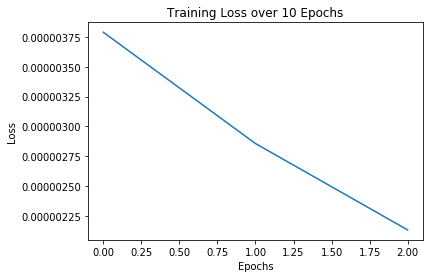

In [95]:
plt.plot(list(range(len(train_loss))),train_loss)
plt.title('Training Loss over 10 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [154]:
model.eval()
#with torch.no_grad():
for inputs, target in test:
            output = model(inputs) # generate output
            prediction = torch.sigmoid(output).tolist() # strangely sigmoid is used here and not in the net iself.
            prediction = np.array(prediction).reshape(1,-1) 
            prediction = np.where(prediction<0.5,0,1).squeeze() # manipulations to put it into a format suitable for comparison against the target vector.
            #print(prediction)
            target_vector = target.numpy()

            comparison_vector = target_vector - prediction
            accuracy = sum(1 for val in comparison_vector if val==0)/ len(comparison_vector)
            print(round(accuracy,4))

0.9187
